In [28]:
!pip install -U ucimlrepo 

import pandas as pd
import sklearn as skl
from ucimlrepo import fetch_ucirepo
import math
import numpy as np
import queue
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import time
import heapq

In [4]:
plt.rcParams ['figure.figsize'] = [10, 7]
sns.set();

In [5]:
# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
df = iris.data.original

# metadata
print(iris.metadata)

# variable information
print(iris.variables)

{'uci_id': 53, 'name': 'Iris', 'repository_url': 'https://archive.ics.uci.edu/dataset/53/iris', 'data_url': 'https://archive.ics.uci.edu/static/public/53/data.csv', 'abstract': 'A small classic dataset from Fisher, 1936. One of the earliest known datasets used for evaluating classification methods.\n', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 150, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1936, 'last_updated': 'Tue Sep 12 2023', 'dataset_doi': '10.24432/C56C76', 'creators': ['R. A. Fisher'], 'intro_paper': {'title': 'The Iris data set: In search of the source of virginica', 'authors': 'A. Unwin, K. Kleinman', 'published_in': 'Significance, 2021', 'year': 2021, 'url': 'https://www.semanticscholar.org/paper/4599862ea877863669a6a8e63a3c707a787d5d7e', 'doi': '1740-9713.01589'}, 'add

In [6]:
df.head(5)

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Let's perform a simple exploratory data analysis to identify duplicates, missing values, and unusual patterns in the dataset.

In [7]:
# Show duplicates
df[df.duplicated(keep = False)]

,sepal length,sepal width,petal length,petal width,class
9,4.9,3.1,1.5,0.1,Iris-setosa
34,4.9,3.1,1.5,0.1,Iris-setosa
37,4.9,3.1,1.5,0.1,Iris-setosa
101,5.8,2.7,5.1,1.9,Iris-virginica
142,5.8,2.7,5.1,1.9,Iris-virginica


In [8]:
# Remove them from the dataset
df = df.drop_duplicates()

df[df.duplicated(keep = False)]

,sepal length,sepal width,petal length,petal width,class


Conclusion: As a result of the check, we have received an empty dataset, indicating that there are no duplicate entries in the data.

In [680]:
# Check missing data
df.isnull().any()

sepal length    False
sepal width     False
petal length    False
petal width     False
class           False
dtype: bool

Conclustion: there is no missing data

In [9]:
df.describe()

,sepal length,sepal width,petal length,petal width
count,147.000000,147.000000,147.000000,147.000000
mean,5.856463,3.055782,3.780272,1.208844
std,0.829100,0.437009,1.759111,0.757874
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.400000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Text(0.5, 1.0, 'Sepal length histogram')

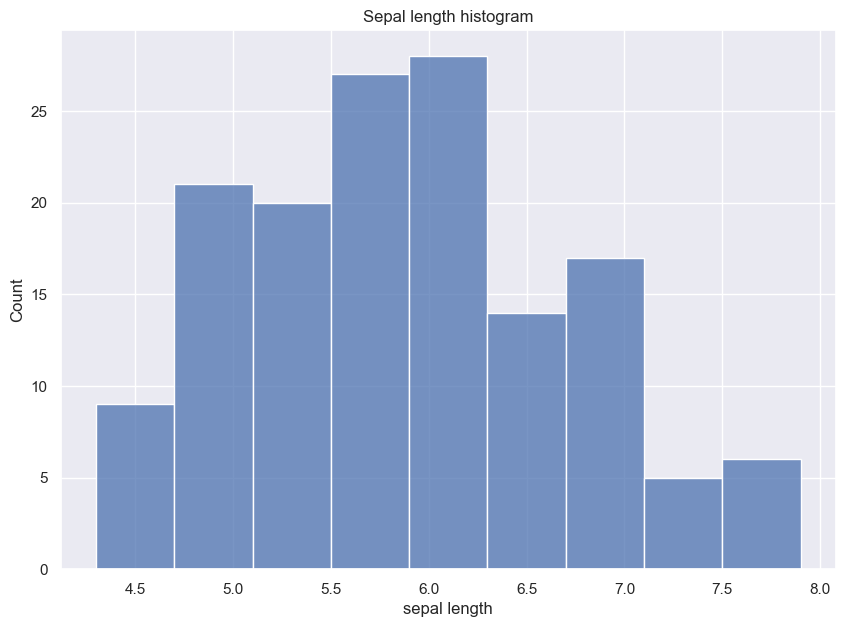

In [10]:
sns.histplot(data=df['sepal length'])

plt.title('Sepal length histogram')

Text(0.5, 1.0, 'Sepal width histogram')

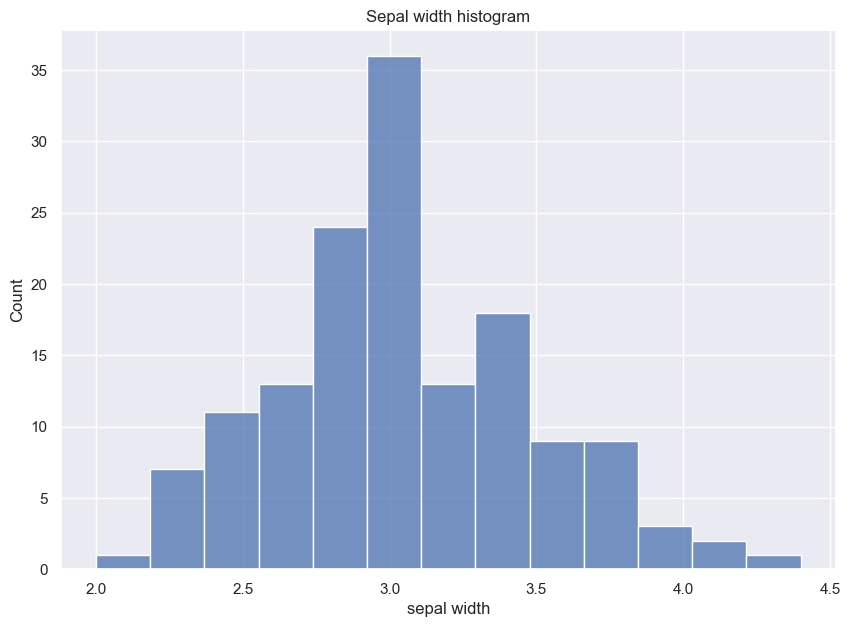

In [11]:
sns.histplot(data=df['sepal width'])
plt.title('Sepal width histogram')

Text(0.5, 1.0, 'Petal length histogram')

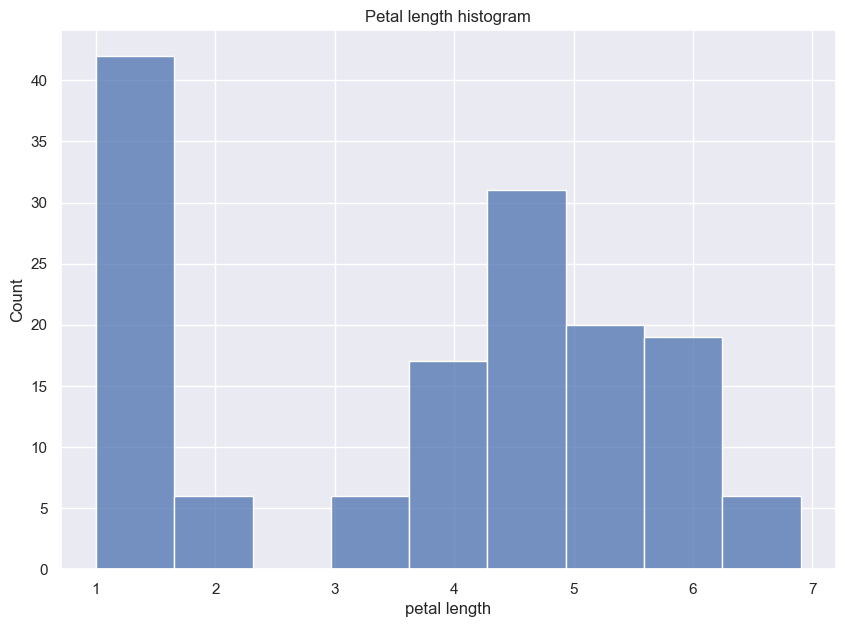

In [12]:
sns.histplot(data=df['petal length'])
plt.title('Petal length histogram')

Text(0.5, 1.0, 'Petal width histogram')

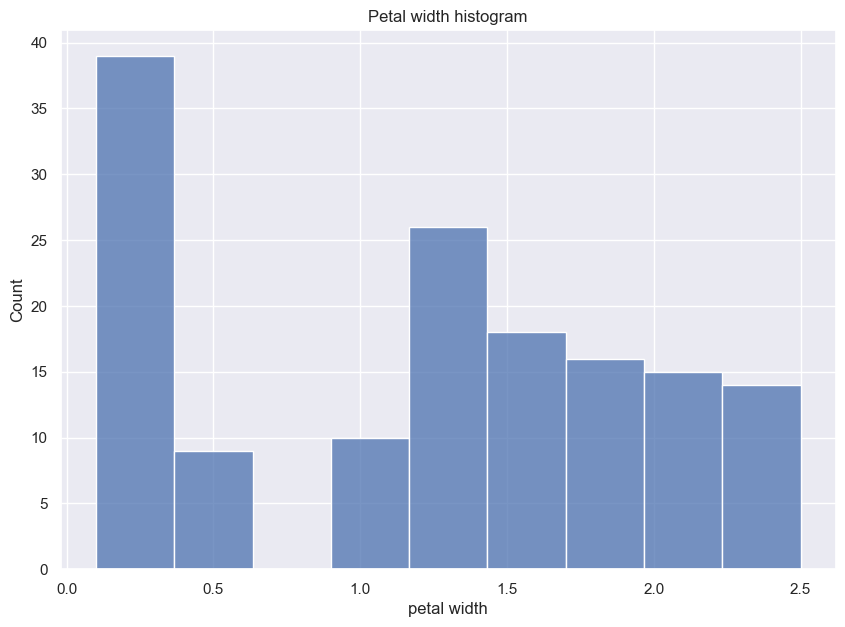

In [13]:
sns.histplot(data=df['petal width'])
plt.title('Petal width histogram')

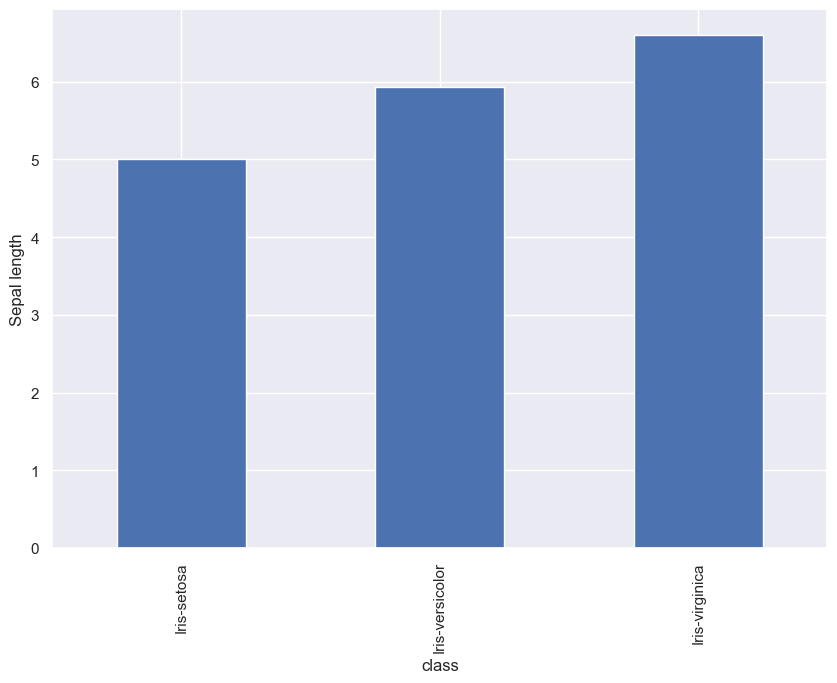

In [15]:
df.groupby('class')['sepal length'].mean().plot(kind='bar') 
plt.ylabel('Sepal length') 
plt.show();

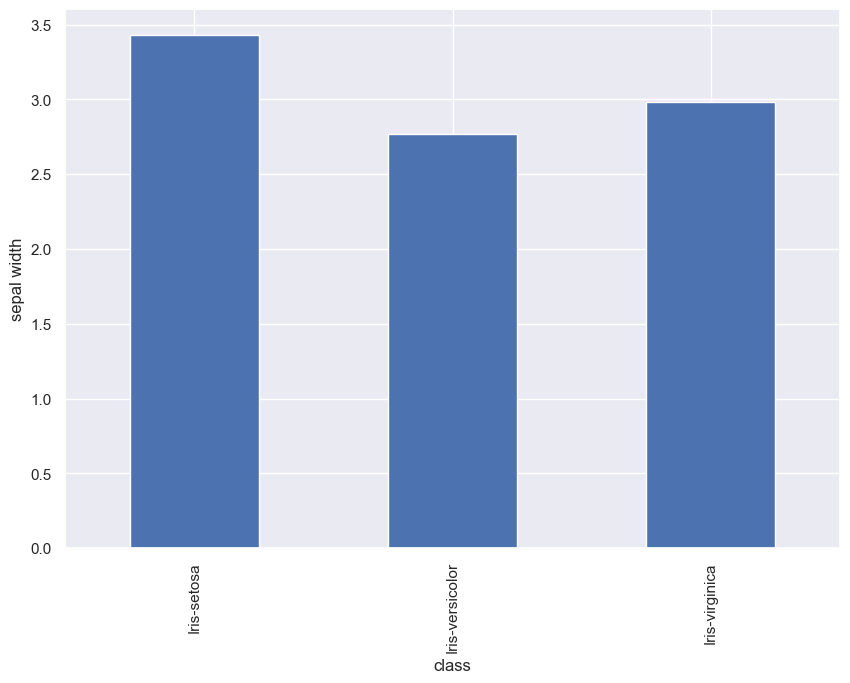

In [16]:
df.groupby('class')['sepal width'].mean().plot(kind='bar') 
plt.ylabel('sepal width') 
plt.show();

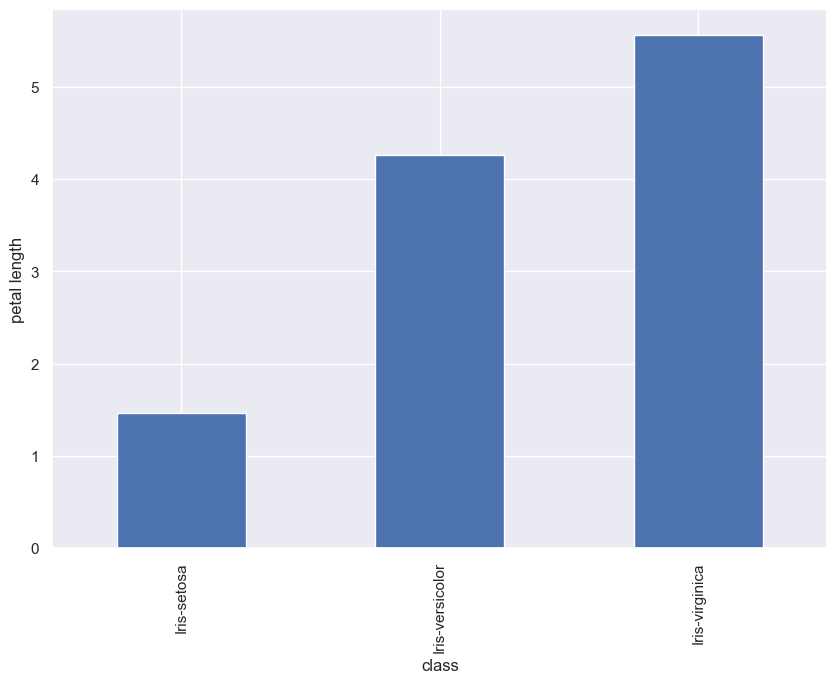

In [17]:
df.groupby('class')['petal length'].mean().plot(kind='bar') 
plt.ylabel('petal length') 
plt.show();

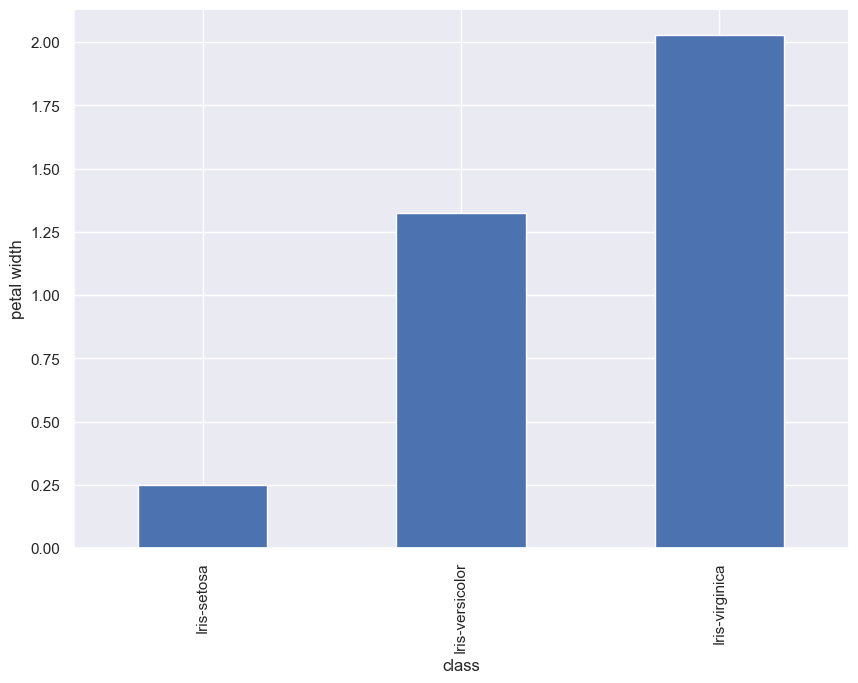

In [18]:
df.groupby('class')['petal width'].mean().plot(kind='bar') 
plt.ylabel('petal width') 
plt.show();

<Axes: >

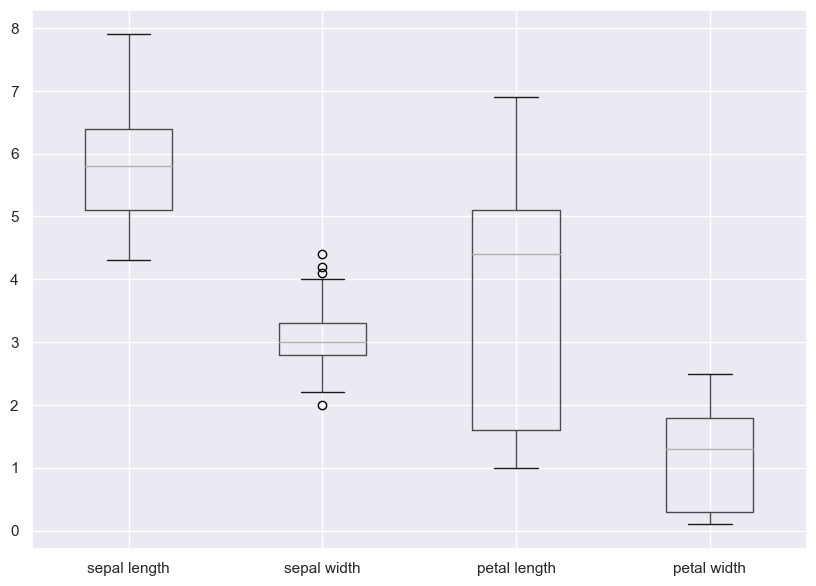

In [19]:
# Let's check if there are any incorrect values in the dataset.
df.boxplot(column = ['sepal length', 'sepal width', 'petal length', 'petal width'])

Conclusion: There are no negative values (all numbers are positive), and there are no extreme outliers in the data.

# Custom kNN classifier example

Split the dataset into training and testing parts

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('class', axis = 1),
                                                    df['class'],
                                                    test_size = 0.2,
                                                    random_state = 54545)

In [22]:
## Different metrices for the classifier
def euclid_distance(point_1, point_2):
    return np.linalg.norm(point_1 - point_2)

def manhattan_distance(point_1, point_2):
    return sum(abs(point_1 - point_2))

## Ядра
def linear_kernel(dist, max_dist):
    return (max_dist - dist)/max_dist

def quadric_kernel(dist, max_dist):
    return (max_dist ** 2 - (dist/max_dist) ** 2)/(max_dist ** 2)

kNN implementation based on Parzen-Rosenblatt method

In [23]:
class MyKNearestNeighbors:
    def __init__(self, k, distance_metric, x_train, y_train, mode = "Standard", kernel = None, max_dist = None):
        self.k = k
        self.distance_metric = distance_metric
        self.x_train = x_train
        self.y_train = y_train
        self.mode = mode
        
        ## Parzen params
        self.kernel = kernel
        self.max_dist = max_dist
        
        
    def neighbours(self, input_x):
        if self.mode == "Standard":
            return self._neighbours_standard(input_x)
        if self.mode == "Parzen":
            return self._neighbours_parzen(input_x)
            
    
    def _neighbours_standard(self, input_x):
        heap = []
        heapq.heapify(heap)
        for x,y in zip(self.x_train, self.y_train):
            dist = self.distance_metric(input_x,x)
            heapq.heappush(heap, (-dist + np.random.normal(-1e-12,1e-12),y))
            if len(heap) > self.k:
                heapq.heappop(heap)
            
        return heap
    
    def _neighbours_parzen(self, input_x):
        heap = []
        heapq.heapify(heap)
        for x,y in zip(self.x_train, self.y_train):
            dist = self.distance_metric(input_x,x)
            if dist >= self.max_dist:
                continue
            heapq.heappush(heap, (-self.kernel(dist, self.max_dist) + np.random.normal(-1e-12,1e-12),y))
        return heap
    
    def predict(self, x_input):
        neighbours = self.neighbours(x_input)
        cnt_dict = {}
        for ngh in neighbours:
            label = ngh[1]
            if label in cnt_dict:
                cnt_dict[label] += 1
            else:
                cnt_dict[label] = 1
        return max(cnt_dict, key=cnt_dict.get)
 
    def predict_dataset(self, x_test):
        res = []
        for x in x_test:
            res.append(self.predict(x))
        return np.array(res)
            

In [30]:
## Comparing sklearn and custom implementations
def comparasion_models(kmin, kmax, my_model, distance_metric, X_train, y_train, X_test, y_test):
    stats = pd.DataFrame(columns = ['my_model','my_model_time', 'skl_model',"sklean_model_time", 'k_value'])

    for k in range (kmin, kmax+1):
        knn = KNeighborsClassifier(k,metric='euclidean').fit(X_train, y_train)
        my_knn = my_model(k, distance_metric, X_train, y_train)
        t1 = time.time()
        sk_pred = knn.predict(X_test)
        t2 = time.time()
        sklearn_time = t2 - t1
        
        t1 = time.time()
        my_pred = my_knn.predict_dataset(X_test)
        t2 = time.time()
        my_knn_time = t2 - t1

        sk_er = f1_score(y_test, sk_pred, average = 'micro')
        my_er = f1_score(y_test, my_pred, average = 'micro')
        result = {'my_model' : round(my_er, 2),
                  'my_model_time': my_knn_time,
                  'skl_model' : round(sk_er, 2),
                  'sklean_model_time': sklearn_time,
                  'k_value' : k}

        stats = pd.concat([stats, pd.DataFrame(result, index = [k])])
    return stats

In [31]:
comparasion_models(1, 20,MyKNearestNeighbors, euclid_distance, X_train.to_numpy(), y_train, X_test.to_numpy(), y_test.to_numpy())

,my_model,my_model_time,skl_model,sklean_model_time,k_value
1,0.90,0.023302,0.90,0.005914,1
2,0.93,0.012953,0.87,0.002915,2
3,0.93,0.010074,0.93,0.001194,3
4,0.97,0.008780,0.97,0.001117,4
5,0.93,0.008029,0.93,0.000823,5
6,0.93,0.007416,0.93,0.000722,6
7,0.97,0.007451,0.93,0.000700,7
8,0.90,0.007424,0.93,0.000751,8
9,0.97,0.007359,0.97,0.000705,9
10,0.90,0.007577,0.93,0.000695,10
